```{admonition} Lecture Materials
:class: tip
[Download the slide deck for this lecture](/_static/pdf/Lecture7-NonlinearEquations-2.pdf)
```

# Polynomials and their roots

Polynomials play an important role in numerical analysis and computational physics. 
According to the [Fundamental Theorem of Algebra](https://en.wikipedia.org/wiki/Fundamental_theorem_of_algebra), every non-constant polynomial has at least one root.
Many special polynomials are used in numerical analysis, such as Legendre polynomials, Chebyshev polynomials, and Laguerre polynomials which have $n$ real roots.

The methods we learned so far can be used to find only one root at a time.
Let us explore some methods that can find all roots of a polynomial.

In [5]:
import numpy as np

import matplotlib.pyplot as plt
# Default style parameters (feel free to modify as you see fit)
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'xtick.direction':'in',
         'ytick.direction':'in',
         }
plt.rcParams.update(params)

accuracy = 1.e-12

In [6]:
last_bisection_iterations = 0  # Count how many interactions it took
bisection_verbose = False

def bisection_method(
    f,                    # The function whose root we are trying to find
    a,                    # The left boundary
    b,                    # The right boundary
    tolerance = 1.e-10,   # The desired accuracy of the solution
    ):
    fa = f(a)                           # The value of the function at the left boundary
    fb = f(b)                           # The value of the function at the right boundary
    if (fa * fb > 0.):
        return None                     # Bisection method is not applicable
    
    global last_bisection_iterations
    last_bisection_iterations = 0
    
    
    while ((b-a) > tolerance):
        last_bisection_iterations += 1
        c = (a + b) / 2.                # Take the midpoint
        fc = f(c)                       # Calculate the function at midpoint
        
        
        if bisection_verbose:
            print("Iteration: {0:5}, c = {1:20.15f}, f(c) = {2:10.15f}".format(last_bisection_iterations, c, fc))
        
        if (fc * fa < 0.):              
            b = c                       # The midpoint is the new right boundary
            fb = fc
        else:                           
            a = c                       # The midpoint is the new left boundary
            fa = fc

    return (a+b) / 2.                   

In [7]:
last_newton_iterations = 0
newton_verbose = True

def newton_method(
    f,                    # The function whose root we are trying to find
    df,                   # The derivative of the function
    x0,                   # The initial guess
    tolerance = 1.e-10,   # The desired accuracy of the solution
    max_iterations = 100  # Maximum number of iterations
    ):
    
    xprev = xnew = x0
    
    global last_newton_iterations
    last_newton_iterations = 0
    diff = 0.
    
    if newton_verbose:
        print("Iteration: {0:5}, x = {1:20.15f}, f(x) = {2:10.15f}".format(last_newton_iterations, x0, f(x0)))
    
    for i in range(max_iterations):
        last_newton_iterations += 1
           
        xprev = xnew
        fval  = f(xprev)                       # The current function value
        dfval = df(xprev)                      # The current function derivative value
        
        if dfval == 0.:
            print("Newton's method: the derivative is zero!")
            return None
        
        xnew = xprev - fval / dfval            # The next iteration
        
        if newton_verbose:
            print("Iteration: {0:5}, x = {1:20.15f}, f(x) = {2:10.15f}".format(last_newton_iterations, xnew, f(xnew)))


        if (abs(xnew-xprev) < tolerance):
            return xnew
        
    
    print("Newton-Raphson method failed to converge to a required precision in " + str(max_iterations) + " iterations")
    # print("The error estimate is ", abs(xnew-xprev))
    
    return None                   

## Polynomial

Polynomial $P(x)$ of order $n$ has a general expression

$$
P(x) = \sum_{j=0}^n a_j \, x^j
$$

For calculations we write it in a form

$$
P(x) = a_0 + x (a_1 + x ( \ldots ))
$$

This allows one to define iterative procedure for calculation of $P(x)$ as well as its derivative $P'(x)$

In [8]:
# Evaluate the polynomial with coefficients a
# at a point x
def Poly(x,a):
    ret = a[len(a) - 1]
    for j in range(len(a) - 2, -1, -1):
        ret = ret * x + a[j]
    return ret

# Evaluate the derivative of a polynomial 
# with coefficients a at a point x
def dPoly(x,a):
    p = a[len(a) - 1]
    dp = 0.
    for j in range(len(a) - 2, -1, -1):
        dp = dp * x + p
        p = p * x + a[j]
    return dp

## Multiplication and division

Let us multiply $P(x)$ by $(x-c)$. The result is a polynomial $\tilde{P}(x)$ of order $n+1$:

$$
\tilde{P}(x) = (x-c) \, P(x) = \sum_{j=0}^{n+1} \tilde{a}_j x^j.
$$

The coefficients $\tilde{a}_j(x)$ can be readily expressed in terms of $a_j(x)$:

$$
\tilde{a}_j = a_{j-1} - c \, a_j, \qquad j = 1,\ldots,n+1,
$$

and

$$
\tilde{a}_0 = -c a_0 .
$$

These relations can also be inverted to express coefficients $a_j$ of $P(x) = \tilde{P(x)} / (x-c)$ in terms of $\tilde{a}_j$ defining the division of a polynomial (deflation):

$$
a_j = \tilde{a}_{j+1} + c \, a_{j+1}, \quad j = 0,\ldots,n
$$

with $a_{n+1} = 0$.

Of course, the deflation (division) by $(x-c)$ presented here only makes sense if $x=c$ is a root of $P(x)$.

In [9]:
# Multiply polynomial by (x - c)
def PolyMult(a,c):
    n = len(a)
    ret = a[:]
    ret.append(ret[-1])
    for j in range(n-1,0,-1):
        ret[j] = ret[j-1] - c * ret[j]
    ret[0] = -c * ret[0]
    return ret

# Divide the polynomial by (x - c), 
# assuming x = c is one of the roots
def PolyDiv(a,c):
    n = len(a) - 1
    ret = a[:]
    ret[-1] = 0.
    for j in range(n-1,-1,-1):
        ret[j] = a[j+1] + c * ret[j+1]
    ret.pop()
    return ret

### Example: Legendre polynomials

Let us now consider a specific example of a polynomial, namely the 6th order Legendre polynomial $P_6(x)$:

$$
P_6(x) = \frac{1}{16} \left( 231 x^6 - 315 x^4 + 105 x^2 - 5 \right).
$$

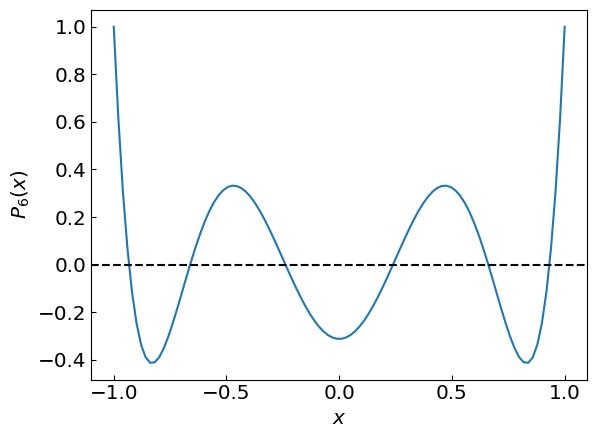

In [10]:
coefficients_Legendre6 = [-5./16., 0., 
                          105./16., 0., 
                          -315./16., 0., 
                          231./16.]

def fP6(x):
    return Poly(x,coefficients_Legendre6)

def dfP6(x):
    return dPoly(x,coefficients_Legendre6)

xplot = np.linspace(-1,1,100)

plt.xlabel("${x}$")
plt.ylabel('${P_6(x)}$')
plt.plot(xplot,fP6(xplot),label = '${y_1}')
plt.axhline(y = 0., color = 'black', linestyle = '--')
#plt.plot([1.841406], [0], 'ro')
plt.show()

Let us use $P_6(x)$ to test polynomial multiplication and deflation

In [11]:
coef1 = coefficients_Legendre6
iters = 5
xc = 0.7

print("Coefficients before multiplication:", coef1)
for i in range(0,iters):
    coef1 = PolyMult(coef1,xc)
    
print(" Coefficients after multiplication:", coef1)
for i in range(0,iters):
    coef1 = PolyDiv(coef1,xc)

print("       Coefficients after division:", coef1)

Coefficients before multiplication: [-0.3125, 0.0, 6.5625, 0.0, -19.6875, 0.0, 14.4375]
 Coefficients after multiplication: [0.05252187499999998, -0.37515624999999997, -0.031084374999999775, 6.347031249999998, -18.106746875, 8.208906250000002, 42.132864375, -72.57403125, 19.38562500000001, 51.05624999999999, -50.53125, 14.4375]
       Coefficients after division: [-0.312499999999972, 2.6645352591003757e-14, 6.562500000000022, 1.4210854715202004e-14, -19.687499999999996, 0.0, 14.4375]


We recover the coefficients after multiplying and dividing the polynomial by same factor several times in a row, although this procedure introduces visible round-off error. One thus has to be mindful of the error accumulation

### Roots of polynomials

Roots of the Legendre polynomials play an important role, for instance, when applied to numerical integration (such as Gauss-Legendre quadratures).

Let us evaluate the roots using what we learned so far.

#### Visual inspection and bisection

$P_6(x)$ has six roots on the real axis. By plotting $P_6(x)$ we can easily figure out the brackets for each root and use the bisection method to evaluate the roots to desired precision

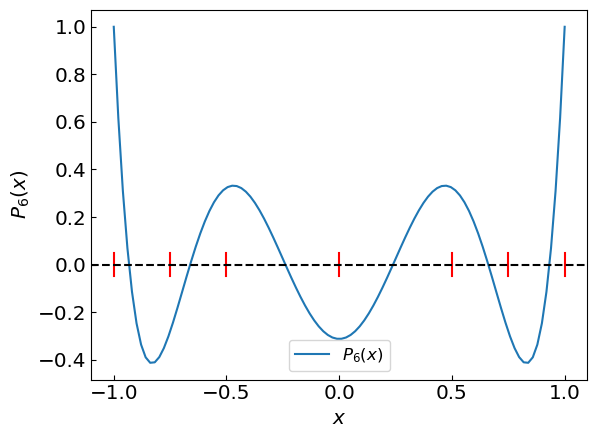

In [12]:
xplot = np.linspace(-1,1,100)

plt.xlabel("${x}$")
plt.ylabel('${P_6(x)}$')
plt.plot(xplot,fP6(xplot),label = '${P_6(x)}$')
#plt.plot(xroots,[0. for k in range(0,6)], 'ro', label = 'roots')
plt.plot([-1.,-1.],[-0.05,0.05], color='red')
plt.plot([-0.75,-0.75],[-0.05,0.05], color='red')
plt.plot([-0.5,-0.5],[-0.05,0.05], color='red')
plt.plot([0.,0.],[-0.05,0.05], color='red')
plt.plot([0.5,0.5],[-0.05,0.05], color='red')
plt.plot([0.75,0.75],[-0.05,0.05], color='red')
plt.plot([1.,1.],[-0.05,0.05], color='red')
plt.axhline(y = 0., color = 'black', linestyle = '--')
plt.legend()
plt.show()

Root 1 between -1.0 and -0.75 is x = -0.9324695142277051
Root 2 between -0.75 and -0.5 is x = -0.6612093864532653
Root 3 between -0.5 and 0.0 is x = -0.23861918607144617
Root 4 between 0.0 and 0.5 is x = 0.23861918607144617
Root 5 between 0.5 and 0.75 is x = 0.6612093864532653
Root 6 between 0.75 and 1.0 is x = 0.9324695142277051


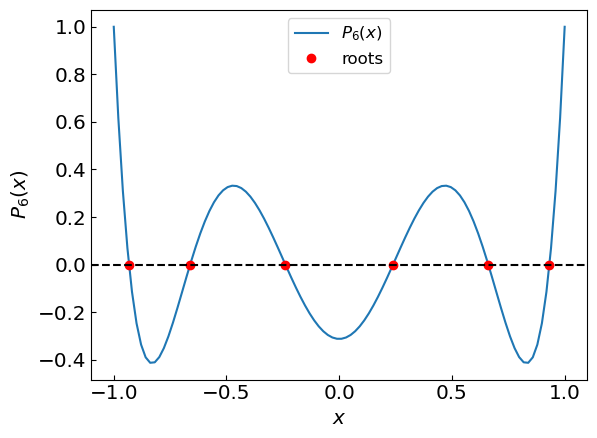

In [13]:
xroots = []

# Root 1
xleft = -1. 
xright = -0.75
xroots.append(bisection_method(fP6,xleft,xright))
print("Root 1 between", xleft, "and", xright, "is x =",xroots[-1])
xleft = -0.75 
xright = -0.5
xroots.append(bisection_method(fP6,xleft,xright))
print("Root 2 between", xleft, "and", xright, "is x =",xroots[-1])
xleft = -0.5
xright = 0.
xroots.append(bisection_method(fP6,xleft,xright))
print("Root 3 between", xleft, "and", xright, "is x =",xroots[-1])
xleft = 0.
xright = 0.5
xroots.append(bisection_method(fP6,xleft,xright))
print("Root 4 between", xleft, "and", xright, "is x =",xroots[-1])
xleft = 0.5 
xright = 0.75
xroots.append(bisection_method(fP6,xleft,xright))
print("Root 5 between", xleft, "and", xright, "is x =",xroots[-1])
xleft = 0.75
xright = 1.
xroots.append(bisection_method(fP6,xleft,xright))
print("Root 6 between", xleft, "and", xright, "is x =",xroots[-1])

xplot = np.linspace(-1,1,100)

plt.xlabel("${x}$")
plt.ylabel('${P_6(x)}$')
plt.plot(xplot,fP6(xplot),label = '${P_6(x)}$')
plt.plot(xroots,[0. for k in range(0,6)], 'ro', label = 'roots')
plt.axhline(y = 0., color = 'black', linestyle = '--')
plt.legend()
plt.show()

### Newton-Raphson method using polynomial division

Could we devise a procedure to find the roots without relying on manual inspection of the $P_6(x)$ plot which would be easily generalizable to other polynomials?

One way to approach this problem is to use the Newton-Raphson method to find the roots of the polynomial $P_6(x)$. If we start from some initial guess, we may expect the method to converge to the nearest root. 
The question is then how to find the other roots.

We can tackle this problem by applying polynomial division of $P_6(x)$ by $(x - r)$ to find the quotient and then apply the Newton-Raphson method to the quotient to find the other roots.

The algorithm is as follows. For a polynomial $P(x)$ with roots $r_1, r_2, \ldots, r_n$:

1. Start with an initial guess $r_0$.
2. Apply the Newton-Raphson method to find the root $r_1$ of $P(x)$.
3. Apply polynomial division of $P(x)$ by $(x - r_1)$ to find the quotient $Q(x)$.
4. Go back to step 2 and repeat the process until all roots are found.

It should be noted that the procedure is susceptible to the accumulation of round-off errors and may not converge to the correct roots. It may be a good idea to perform a refinement step after each root is found by applying the Newton-Raphson method to the original polynomial $P(x)$ and using the determined roots as the initial guess.

The code for this algorithm is as follows:

In [14]:
def PolyRoots(
    a,                    # The coefficients of the polynomial that we are solving
    x0  = -1.,            # The initial guess for the first root
    accuracy = 1.e-10,    # The desired accuracy of the solution
    polishing = True,     # Whether to polish the roots further with Newton's method
    max_iterations = 100  # Maximum number of iterations in Newton's method
):
    ret = []
    n = len(a)
    apoly = a[:]
    current_root = x0
    
    def f(x):
        return Poly(x,apoly)
    def df(x):
        return dPoly(x,apoly)
    
    print("Searching all the roots using deflation and Newton's method")
    # Loop over all the roots
    for k in range(0,n-1,1):
        current_root = newton_method(f,df,current_root,accuracy,max_iterations)
        if (current_root == None):
            print("Failed to find the next root!")
            break
        ret.append(current_root)
        print("Root ", k+1, "is x = ",current_root)
        # Deflate the polynomial
        apoly = PolyDiv(apoly, current_root)
        
    if polishing:
        print("Polishing the roots by reapplying Newton's method to the original polynomial")
        apoly = a[:]
        for k in range(0,n-1,1):
            ret[k] = newton_method(f,df,ret[k],accuracy,max_iterations)
            print("Root ", k+1, "is x = ",ret[k])
    
    return ret

Let us now apply the above algorithm to find the roots of the polynomial $P_6(x)$.

Searching all the roots using deflation and Newton's method
Root  1 is x =  -0.932469514203152
Root  2 is x =  -0.6612093864662645
Root  3 is x =  -0.23861918608319668
Root  4 is x =  0.23861918608319652
Root  5 is x =  0.6612093864662646
Root  6 is x =  0.9324695142031523
[-0.932469514203152, -0.6612093864662645, -0.23861918608319668, 0.23861918608319652, 0.6612093864662646, 0.9324695142031523]


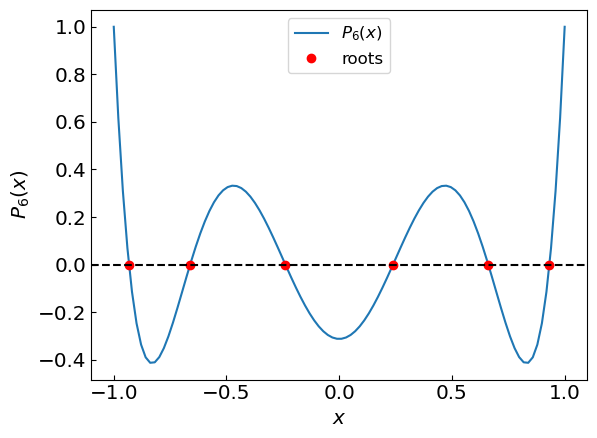

In [15]:
x0 = -1.
newton_verbose = False
polishing = False
xroots = PolyRoots(coefficients_Legendre6, x0, accuracy, polishing)
print(xroots)
xplot = np.linspace(-1.,1.,100)

plt.xlabel("${x}$")
plt.ylabel('${P_6(x)}$')
plt.plot(xplot,fP6(xplot),label = '${P_6(x)}$')
plt.plot(xroots,[0. for k in range(0,len(xroots))], 'ro', label = 'roots')
plt.axhline(y = 0., color = 'black', linestyle = '--')
plt.legend()
plt.show()

In [18]:
# build gif
import imageio.v2 as imageio

filenames = ["poly0.png", "poly1.png", "poly2.png", "poly3.png", "poly4.png", "poly5.png"]

with imageio.get_writer("polyroots.gif", mode='I', loop=0, duration=1000) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

Here is an animation of the deflation process and the successive root-finding:

![polyroots.gif](polyroots.gif)

Now we can straightforwardly calculate the roots of other polynomials

For example, $P_9(x)$:

Searching all the roots using deflation and Newton's method
Root  1 is x =  -0.9681602395076263
Root  2 is x =  -0.8360311073266355
Root  3 is x =  -0.6133714327005905
Root  4 is x =  -0.3242534234038087
Root  5 is x =  -2.9050086835705924e-16
Root  6 is x =  0.32425342340380925
Root  7 is x =  0.6133714327005846
Root  8 is x =  0.8360311073266581
Root  9 is x =  0.968160239507609


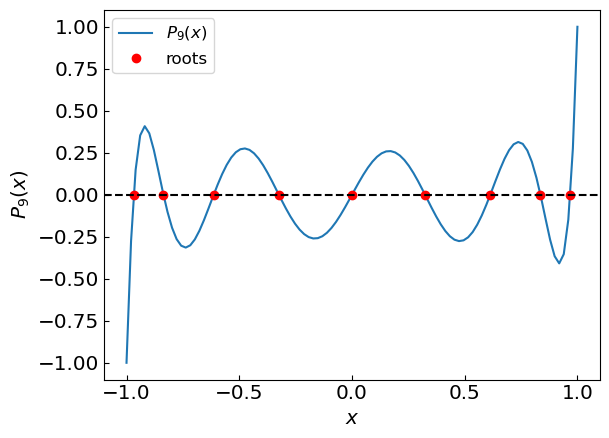

In [16]:
coefficients_Legendre9 = [
    0., 315./128., 
    0., -4620./128., 
    0., 18018./128., 
    0., -25740./128., 
    0., 12155./128.]

x0 = -1.
newton_verbose = False
polishing = False
xroots = PolyRoots(coefficients_Legendre9, x0, accuracy, polishing)
xplot = np.linspace(-1.,1.,100)

plt.xlabel("${x}$")
plt.ylabel('${P_{9}(x)}$')
plt.plot(xplot,Poly(xplot,coefficients_Legendre9),label = '${P_{9}(x)}$')
plt.plot(xroots,[0. for k in range(0,len(xroots))], 'ro', label = 'roots')
plt.axhline(y = 0., color = 'black', linestyle = '--')
plt.legend()
plt.show()

Another example is Hermite polynomials

Searching all the roots using deflation and Newton's method
Root  1 is x =  -2.0201828704560856
Root  2 is x =  -0.9585724646138192
Root  3 is x =  1.0319700683878226e-15
Root  4 is x =  0.9585724646138175
Root  5 is x =  2.0201828704560865
Polishing the roots by reapplying Newton's method to the original polynomial
Root  1 is x =  -2.0201828704560856
Root  2 is x =  -0.9585724646138186
Root  3 is x =  0.0
Root  4 is x =  0.9585724646138185
Root  5 is x =  2.0201828704560856


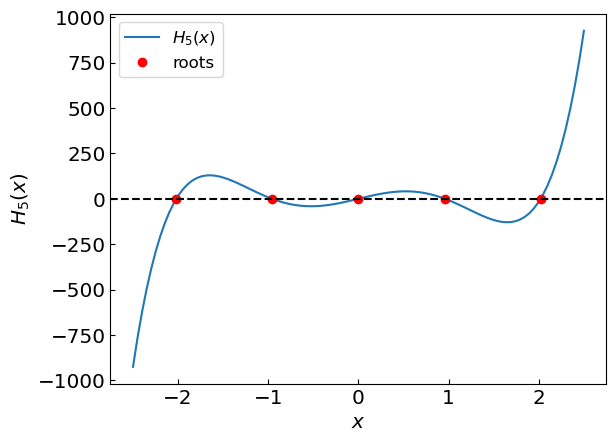

In [17]:
coefficients_Hermite5 = [
    0., 120.,
    0., -160.,
    0., 32.]

x0 = -2.
newton_verbose = False
polishing = True
xroots = PolyRoots(coefficients_Hermite5, x0, accuracy, polishing)

xplot = np.linspace(-2.5,2.5,100)

plt.xlabel("${x}$")
plt.ylabel('${H_{5}(x)}$')
plt.plot(xplot,Poly(xplot,coefficients_Hermite5),label = '${H_{5}(x)}$')
plt.plot(xroots,[0. for k in range(0,len(xroots))], 'ro', label = 'roots')
plt.axhline(y = 0., color = 'black', linestyle = '--')
plt.legend()
plt.show()

## Further methods and reading

- Polynomial root finding as an eigenvalue problem
- [Arbitrary precision arithmetic](https://en.wikipedia.org/wiki/Arbitrary-precision_arithmetic)
- Chapter 9.5 of [*Numerical Recipes Third Edition*](https://numerical.recipes/book.html) by W.H. Press et al.
- [Laguerre's method](https://en.wikipedia.org/wiki/Laguerre%27s_method)